In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

import torchvision
from torchvision import transforms as T
from torchvision import models

import cv2
import matplotlib.pyplot as plt
import numpy as np

import time

In [2]:
def vgg16_feature_maps(vgg16, x):
    ''' Returns feature maps of given layers from vgg16 model
    
        vgg16_model: a pretrained pytorch vgg16 model
        out_layers
    '''
    feature_maps = []
    
    conv_layers = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
    pool_layers = [4, 9, 16, 23, 30]
    avg_pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
    
    for i in range(len(vgg16.features)):       
        if i in conv_layers:
            x = vgg16.features[i](x)
            feature_maps.append(x)
            
        elif i in pool_layers:
            x = avg_pool(x)
            
        else:
            x = vgg16.features[i](x)
            
    return feature_maps


In [3]:
def squeezenet_feature_maps(squeezenet, x):
    feature_maps = []
    
    pooling_layers = [2, 6, 11]
    avg_pool = nn.AvgPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)
 
    # first feature map
    x = squeezenet.features[0](x)
    feature_maps.append(x)

    # skip over first convolution since feature map is already computed
    for i in range(1, len(model.features)):
        feature = squeezenet.features[i]

        # use avg pooling instead of max pooling
        if i in pooling_layers:
            x = avg_pool(x)
            
        # handle feature maps in fire blocks
        elif type(feature) == torchvision.models.squeezenet.Fire:
            x0 = feature.squeeze(x)
            x = feature.squeeze_activation(x0)
            
            x1x1 = feature.expand1x1(x)
            x3x3 = feature.expand3x3(x)
            
            feature_maps = feature_maps + [x0, torch.cat([x1x1, x3x3], 1)]
            #feature_maps = feature_maps + [x0, x1x1, x3x3]
            
            x = torch.cat([
                feature.expand1x1_activation(x1x1), 
                feature.expand3x3_activation(x3x3)
            ], 1)
            
        # all other non feature map layers
        else:
            x = feature(x)
            
    return feature_maps
    

In [4]:
def gram_matrix(features):
    n, c, h, w = features.shape
    features = features.view(c, h*w)
            
    return features.matmul(features.T)

def style_loss(img_features, style_features):  
    loss = 0
    
    for img_feature, style_feature in zip(img_features, style_features):
        img_gram = gram_matrix(img_feature)
        style_gram = gram_matrix(style_feature)

        loss += F.l1_loss(img_gram, style_gram)
        
    return loss


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

mobilenet = models.mobilenet_v2(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

model = squeezenet
model = model.to(device).eval()
feature_map_fn = squeezenet_feature_maps

for param in model.parameters():
    param.requires_grad = False
    

In [6]:
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
def fft_channels(img):
    h, w, c = img.shape
    out = np.zeros_like(img)
    fshifts = np.zeros_like(img, dtype=np.complex128)
    
    for i in range(c):
        f = np.fft.fft2(img[..., i])
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log(np.abs(fshift))
        out[..., i] = magnitude_spectrum
        fshifts[..., i] = fshift
        
    return fshifts, out

fshifts, out = fft_channels(target_content)
out = (out - out.min()) / (out.max() - out.min())
plt.subplot(121),plt.imshow(target_content, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(out)
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
def ifft_channels(fshifts):
    h, w, c = fshifts.shape
    out = np.zeros((h, w, c))
    
    for i in range(c):
        f_ishift = np.fft.ifftshift(fshifts[..., i])
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)
        out[..., i] = img_back
    return out

plt.subplot(131),plt.imshow(target_content)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(out)
plt.title('Image after FFT'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(ifft_channels(fshifts).astype(np.uint8))
plt.title('Result after IFFT'), plt.xticks([]), plt.yticks([])

plt.show()

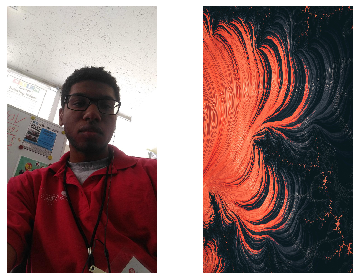

In [16]:
target_content = cv2.imread('./content/me.jpg', cv2.IMREAD_COLOR)
target_style = cv2.imread('./styles/fractal.jpg', cv2.IMREAD_COLOR)

shape = target_content.shape[:2][::-1]
shape = (1280, 720)[::-1]
target_content = cv2.cvtColor(cv2.resize(target_content, shape), cv2.COLOR_BGR2RGB)
target_style = cv2.cvtColor(target_style, cv2.COLOR_BGR2RGB)

H, W, C = target_content.shape
h, w, c = target_style.shape

# for tiling
y = H/h
y = int(y) if y == int(y) else int(y+1)

x = W/w
x = int(x) if x == int(x) else int(x+1)

target_style = cv2.resize(target_style, (target_content.shape[:2][::-1]))
#target_style = np.tile(target_style, (y, x, 1))[:H, :W]

#content_shifts, target_content_fft = fft_channels(target_content)
#style_shifts, target_style_fft = fft_channels(target_style)

def scale_for_viewing(img):
    return (img - img.min()) / (img.max() - img.min())

fig, ax = plt.subplots(1, 2)
ax[0].imshow(scale_for_viewing(target_content))
ax[1].imshow(scale_for_viewing(target_style))

for i in range(2):
    ax[i].axis('off')
    
plt.tight_layout()

In [28]:
shape = (1, 3, target_content.shape[0], target_content.shape[1])

style_transforms = T.Compose([
    T.ToPILImage(),
    T.RandomVerticalFlip(),
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop(tuple(target_content.shape[:2])),
    T.ToTensor(),
])
target_content_ = T.ToTensor()(target_content).view(shape).to(device)
target_style_ = style_transforms(target_style).view(shape).to(device)

img = Variable(T.ToTensor()(target_content).view(shape).to(device), requires_grad=True)
optimizer = optim.Adam([img], 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

content_features = feature_map_fn(model, target_content_)
#style_features = feature_map_fn(model, target_style_)

epochs = 500

alpha = 1
beta = 1000000 # apparently style should be weighted heavily

start_time = time.time()

for epoch in range(epochs):
    style_features = feature_map_fn(model, style_transforms(target_style).view(shape).to(device))
    img.grad = None
    features = feature_map_fn(model, img)

    content_loss_ = F.l1_loss(features[-1], content_features[-1])
    style_loss_ = style_loss(features, style_features)
    total_loss = alpha * content_loss_ + beta * style_loss_
    
    print(f'{epoch+1}) C Loss: {alpha*content_loss_:.4f} | S Loss: {beta*style_loss_:.4f}')
    total_loss.backward()
    optimizer.step()
    #scheduler.step()
    
    # keep values on the interval [0, 1] to correctly convert to rgb image
    img.data.clamp_(0, 1)
    
print(f'Seconds elapsed: {time.time() - start_time}')

1) C Loss: 0.0000 | S Loss: 16188340961280.0000
2) C Loss: 1.7694 | S Loss: 10647250141184.0000
3) C Loss: 3.1740 | S Loss: 7965539565568.0000
4) C Loss: 3.6249 | S Loss: 7166947229696.0000
5) C Loss: 3.8687 | S Loss: 7341039681536.0000
6) C Loss: 4.0108 | S Loss: 6739990151168.0000
7) C Loss: 4.0057 | S Loss: 5049292947456.0000
8) C Loss: 4.0304 | S Loss: 4385778958336.0000
9) C Loss: 4.1053 | S Loss: 5489161142272.0000
10) C Loss: 4.1478 | S Loss: 4361628942336.0000
11) C Loss: 4.1844 | S Loss: 8052679376896.0000
12) C Loss: 4.0901 | S Loss: 5247364759552.0000
13) C Loss: 4.0620 | S Loss: 8364565200896.0000
14) C Loss: 4.0825 | S Loss: 3465982246912.0000
15) C Loss: 4.1092 | S Loss: 5018075791360.0000
16) C Loss: 4.2077 | S Loss: 6161596153856.0000
17) C Loss: 4.3547 | S Loss: 4798742528000.0000
18) C Loss: 4.5718 | S Loss: 4422013812736.0000
19) C Loss: 4.6538 | S Loss: 3711471714304.0000
20) C Loss: 4.6318 | S Loss: 3211101995008.0000
21) C Loss: 4.6117 | S Loss: 6665116581888.0000

170) C Loss: 5.1320 | S Loss: 6017847918592.0000
171) C Loss: 5.1329 | S Loss: 8798290837504.0000
172) C Loss: 5.1481 | S Loss: 4255705989120.0000
173) C Loss: 5.1020 | S Loss: 4291126886400.0000
174) C Loss: 5.0847 | S Loss: 2811590082560.0000
175) C Loss: 5.1205 | S Loss: 5752453332992.0000
176) C Loss: 5.1974 | S Loss: 3091354353664.0000
177) C Loss: 5.2919 | S Loss: 4859332919296.0000
178) C Loss: 5.3718 | S Loss: 4317595566080.0000
179) C Loss: 5.4009 | S Loss: 3604949237760.0000
180) C Loss: 5.4226 | S Loss: 2562846097408.0000
181) C Loss: 5.4102 | S Loss: 2866279874560.0000
182) C Loss: 5.3537 | S Loss: 5147104116736.0000
183) C Loss: 5.2844 | S Loss: 5434234109952.0000
184) C Loss: 5.2594 | S Loss: 3397521244160.0000
185) C Loss: 5.2867 | S Loss: 4539101478912.0000
186) C Loss: 5.2680 | S Loss: 4359763525632.0000
187) C Loss: 5.2353 | S Loss: 3318333308928.0000
188) C Loss: 5.1820 | S Loss: 4155189231616.0000
189) C Loss: 5.1682 | S Loss: 3172504174592.0000
190) C Loss: 5.1883 

338) C Loss: 5.1852 | S Loss: 2906783481856.0000
339) C Loss: 5.2916 | S Loss: 4183416635392.0000
340) C Loss: 5.4030 | S Loss: 4669007462400.0000
341) C Loss: 5.4952 | S Loss: 2015039324160.0000
342) C Loss: 5.5423 | S Loss: 3454809407488.0000
343) C Loss: 5.5484 | S Loss: 2758958645248.0000
344) C Loss: 5.5250 | S Loss: 5062766624768.0000
345) C Loss: 5.4495 | S Loss: 4601000493056.0000
346) C Loss: 5.3262 | S Loss: 3179750096896.0000
347) C Loss: 5.2263 | S Loss: 3442271584256.0000
348) C Loss: 5.1368 | S Loss: 2828908888064.0000
349) C Loss: 5.0986 | S Loss: 5625936871424.0000
350) C Loss: 5.1084 | S Loss: 2685243490304.0000
351) C Loss: 5.1556 | S Loss: 5666877997056.0000
352) C Loss: 5.1703 | S Loss: 2420260732928.0000
353) C Loss: 5.2172 | S Loss: 3567979069440.0000
354) C Loss: 5.2000 | S Loss: 5989617631232.0000
355) C Loss: 5.1767 | S Loss: 4817944051712.0000
356) C Loss: 5.1276 | S Loss: 4574314233856.0000
357) C Loss: 5.0580 | S Loss: 7823388311552.0000
358) C Loss: 5.0548 

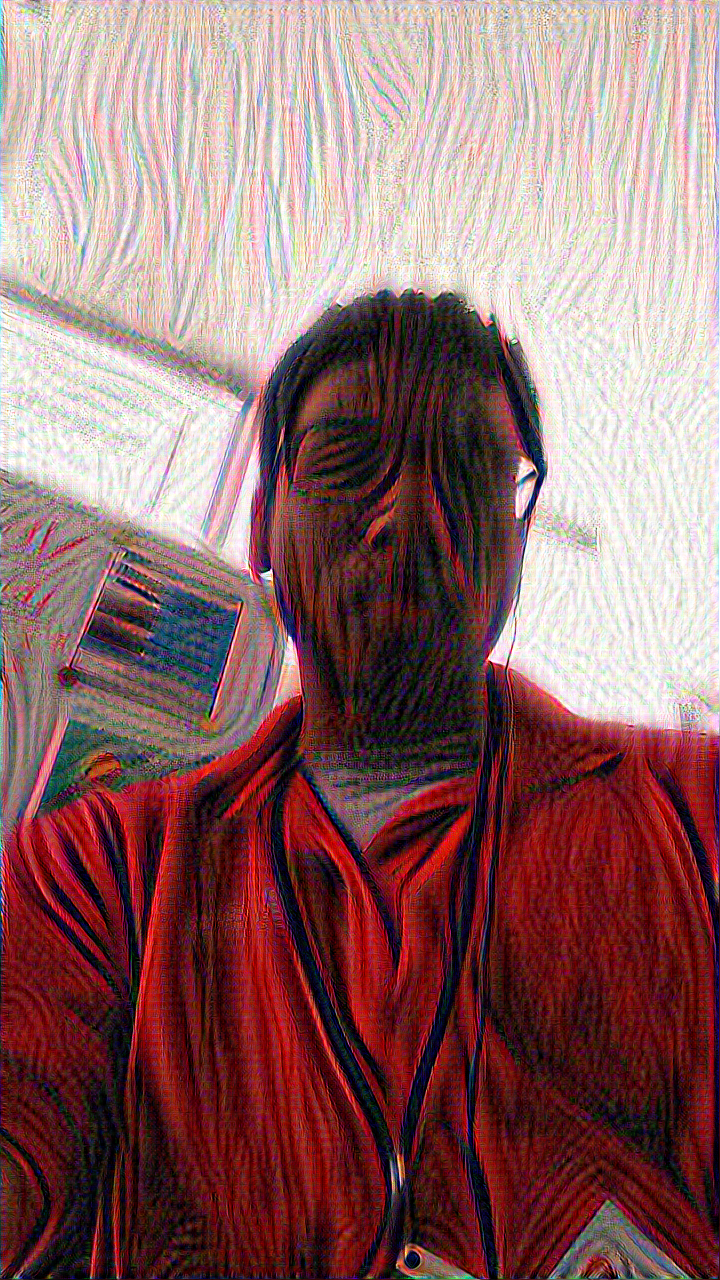

In [29]:
T.ToPILImage()(img[0].cpu())